## download libraries

In [ ]:
!pip install emoji --upgrade
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=2993ee6c88699e92d18115300a4e601621e78559ade4ba2bf6b0574afbcfcedf
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Import necessary libraries for data cleaning, sentiment analysis and word embedding

In [ ]:
import re # for regular expressions
import json
import emoji

import pickle
from datetime import datetime

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)

from nltk import pos_tag, sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet as wn, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%cd "/content/drive/My Drive/dataScience/projects/twitterSentimentAnalysis/dataset"
# !pwd

/content/drive/My Drive/dataScience/projects/twitterSentimentAnalysis/dataset


## Define dictionary for contractions of words



In [ ]:
# Dictionary of contarctions. source for contractions: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
contractions_dict = {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have"
        }

##Read json formatted raw data as a DataFrame

> Indented block



In [ ]:
# Input data files are available in the "dataset/" directory.
# Read the input raw data and parse only the necessary columns from the json file.

def populate_tweet_df(tweets):
    """
    This function takes tweets list as argument and returns a dataframe of the tweets.
    """
    df = pd.DataFrame()
    df['date'] = [datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S %z %Y') for tweet in tweets if (tweet['lang'] == 'en')]
    df['text'] = [tweet['text'] for tweet in tweets if (tweet['lang'] == 'en')]
    # df['text'] = list(map(lambda tweet:tweet['text'], filter(lambda tweet: tweet['lang']=='en', tweets)))
    return df

if __name__ == '__main__':
    tweet_file1 = ("tweets_parisagreement_09-03-2020.txt")
    tweets = []
    with open(tweet_file1, 'r') as file:
        for line in file.readlines():
            tweets.append(json.loads(line))
    
    tweet_file2 = ("tweets_parisagreement_20-04-2020.txt")
    with open(tweet_file2, 'r') as file:
        for line in file.readlines():
            tweets.append(json.loads(line))

    tweets_df = populate_tweet_df(tweets)
    print("Executed Successfully")


Executed Successfully


In [ ]:
tweets_df.head()

,date,text
0,2020-03-09 13:49:46+00:00,One need World to make #MAGA .\nWe need #ParisAgreement to make Earth Great.\n@UNEP @UN @IPCC_CH @SciNetUCS… https://t.co/BJhy83Oyaf
1,2020-03-09 13:26:18+00:00,"SLOW DOWN\nGlobal #CO2 emissions from the #power sector fell by 2% last year, the biggest fall since 1990. The decli… https://t.co/fpb4a59R9k"
2,2020-03-09 13:21:51+00:00,RT @UNDPClimate: This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with #ParisAgreeme…
3,2020-03-09 13:21:42+00:00,RT @UNDPClimate: This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with #ParisAgreeme…
4,2020-03-09 13:20:13+00:00,This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with… https://t.co/SWygs30ODi


##Data Cleaning

In [ ]:
# Setting stopwords
all_stopwords = set(stopwords.words('english'))
exclude_stopwords = ['no', 'not']
for sw in exclude_stopwords:
    all_stopwords.remove(sw)

# Initializing Lemmatizer
lemmatizer = WordNetLemmatizer()

def toLowerCase(text):
    '''
    Returns the text in lowercase.
    '''
    return text.lower()


def removeUrls(text):
    # return re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', text)
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b','', text)

def removeSpecialChar(text):
    '''
    Removes special characters which are generally found in tweets.
    '''
    # Convert @username to empty strings
    # text = re.sub('@[^\s]+', '', text)
    text = re.sub('@\S+','',text)

    # Remove 'RT' from retweets
    text = re.sub(r'\brt\b', '', text)

    # Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)

    # Replace #hastags with white space
    # text = re.sub(r'#([^\s]+)', '', text)
    text = re.sub(r"#\S+", "", text)

    # Trims the tweet
    text = text.strip('\'"')

    return text


def removeNonAlpha(text):
    '''
    Remove all characters which are not alphabets, numbers or whitespaces.
    '''
    return re.sub('[^A-Za-z0-9 ]+', '', text)


def removeStopWords(text):
    # Remove stop words using NLTK's list of stop words in the corpus module. 
    tokens_without_sw = [word for word in word_tokenize(text) if not word in all_stopwords]

    return (tokens_without_sw)


def handleEmojis(text):
    '''
    This function handles sentiments expressed through emoticons by using Python's 'emoji package'.
    Replace all emoticons with the expression they represent in plain English.
    '''
    text = emoji.demojize(text)
    text = text.replace(":"," ")
    text = text.replace("_"," ")
    text = ' '.join(text.split())
    return text


def handleContractions(text):
    '''
    expand shortened words, e.g. convert "don't" to "do not"
    '''
    contracted_tokens = [contractions_dict[word] if word in contractions_dict else word for word in word_tokenize(text)]
    return " ".join(contracted_tokens)


def get_wordnet_pos(word):
    '''
    Map POS tag to the format wordnet lemmatizer would accept. Returning 'NOUN' as default tag.
    ADJ: adjective,    ADP: adposition,    ADV: adverb,    CONJ: conjunction	
    DET: determiner,article,    NOUN: noun,    NUM: numeral,    PRT: particle
    PRON: pronoun,    VERB: verb,    .: punctuation marks	. , ; !,    X: other	
    '''
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}

    return tag_dict.get(tag, wn.NOUN)


def wordLemmatization(text):
    '''
    Lemmatizing the text with the appropriate POS tag
    result: ['he', 'kept', 'eat', 'while', 'we', 'be', 'talk']
    '''
    lemma_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_tokenize(text)]
    return " ".join(lemma_tokens)

def processTweets(tweet):
    '''
    Process the raw tweets and convert them into usable data for sentiment analysis. 
    '''
    # Convert to lower case
    tweet = toLowerCase(tweet)

    # Remove all Special characters
    tweet = removeSpecialChar(tweet)

    # Remove urls
    tweet = removeUrls(tweet)
    
    # Replacing contractions with full words
    tweet = handleContractions(tweet)
    
    # Replace emoticons with word expressions
    tweet = handleEmojis(tweet)
    
    # # Remove all Special characters
    tweet = removeSpecialChar(tweet)
    
    # Remove non alpha characters
    tweet = removeNonAlpha(tweet)
    
    # converting a word to its base form
    tweet = wordLemmatization(tweet)
    
    # Remove stop words
    tweet = removeStopWords(tweet)

    return tweet

if __name__ == '__main__':
    tweets = tweets_df['text']
    processed_tweets = []
    processed_df = pd.DataFrame(columns=['date','text','clean_text'])
    for tweet in tweets:
        processed_tweets.append(processTweets(tweet))
    processed_df['date'] = tweets_df['date']
    processed_df['text'] = tweets_df['text']
    processed_df['clean_text'] = processed_tweets
    print("Executed Successfully")

Executed Successfully


In [ ]:
tweet1 = '''RT @AngholichiGoli Ghana will share their progress on cooperative approaches aligned with #ParisAgreemet'''
tweet2 = '''RT @frances_cutler: are they massively trying to massage the figures to hide the fact😡❓'''
print(processTweets(tweet1))
print(processTweets(tweet2))

['ghana', 'share', 'progress', 'cooperative', 'approach', 'align']
['massively', 'try', 'massage', 'figure', 'hide', 'fact', 'pout', 'face', 'question', 'mark']


In [ ]:
processed_df.head()

,date,text,clean_text
0,2020-03-09 13:49:46+00:00,One need World to make #MAGA .\nWe need #ParisAgreement to make Earth Great.\n@UNEP @UN @IPCC_CH @SciNetUCS… https://t.co/BJhy83Oyaf,"[one, need, world, make, need, make, earth, great]"
1,2020-03-09 13:26:18+00:00,"SLOW DOWN\nGlobal #CO2 emissions from the #power sector fell by 2% last year, the biggest fall since 1990. The decli… https://t.co/fpb4a59R9k","[slow, global, emission, sector, fell, 2, last, year, big, fall, since, 1990, decli]"
2,2020-03-09 13:21:51+00:00,RT @UNDPClimate: This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with #ParisAgreeme…,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]"
3,2020-03-09 13:21:42+00:00,RT @UNDPClimate: This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with #ParisAgreeme…,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]"
4,2020-03-09 13:20:13+00:00,This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with… https://t.co/SWygs30ODi,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]"


###Save processed dataframe for easy reusability

In [ ]:
cleaned_df = open("cleaned_df.pickle","wb")
pickle.dump(processed_df, cleaned_df)

In [ ]:
cleaned_df = open("cleaned_df.pickle", "rb")
processed_df = pickle.load(cleaned_df)

## Hypernyms

In [ ]:
def get_wordnet_pos(word):
    '''
    Convert the PennTreebank tags to simple Wordnet tags
    '''
    tag = pos_tag([word])[0][1][0].upper()

    tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}

    return tag_dict.get(tag, wn.NOUN)

def get_hypernyms(text):

    hypernymn_tweet = []
    
    count = len(text)

    for word in text:
        synsets = wn.synsets(word)

        if len(synsets) <= 0:
            hypernymn_tweet.append(word)
        else:
        # We get the hypernym
            hyper = synsets[0].hypernyms()
        # If we get a result
            if len(hyper) <= 0:
                hypernymn_tweet.append(word)
            else:
                lemmas = hyper[0].lemma_names()
                hypernymn_tweet.append(lemmas[0])
    return hypernymn_tweet

In [ ]:
hypernym_text = []
tweets = processed_df['clean_text']
for tweet in tweets:
    hypernym_text.append(get_hypernyms(tweet))
processed_df['hypernym_text'] = hypernym_text
processed_df.head()

,date,text,clean_text,hypernym_text
0,2020-03-09 13:49:46+00:00,One need World to make #MAGA .\nWe need #ParisAgreement to make Earth Great.\n@UNEP @UN @IPCC_CH @SciNetUCS… https://t.co/BJhy83Oyaf,"[one, need, world, make, need, make, earth, great]","[digit, condition, natural_object, kind, condition, kind, earth, achiever]"
1,2020-03-09 13:26:18+00:00,"SLOW DOWN\nGlobal #CO2 emissions from the #power sector fell by 2% last year, the biggest fall since 1990. The decli… https://t.co/fpb4a59R9k","[slow, global, emission, sector, fell, 2, last, year, big, fall, since, 1990, decli]","[decrease, global, egress, plane_figure, animal_skin, digit, end, time_period, big, season, since, 1990, decli]"
2,2020-03-09 13:21:51+00:00,RT @UNDPClimate: This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with #ParisAgreeme…,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]","[weekday, large_integer, Gregorian_calendar_month, switzerland, current_unit, ghana, assets, development, commercial_enterprise, conceptualization, reorient]"
3,2020-03-09 13:21:42+00:00,RT @UNDPClimate: This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with #ParisAgreeme…,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]","[weekday, large_integer, Gregorian_calendar_month, switzerland, current_unit, ghana, assets, development, commercial_enterprise, conceptualization, reorient]"
4,2020-03-09 13:20:13+00:00,This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with… https://t.co/SWygs30ODi,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]","[weekday, large_integer, Gregorian_calendar_month, switzerland, current_unit, ghana, assets, development, commercial_enterprise, conceptualization, reorient]"


## Word Embedding and Reaplcing words with centroid of the clusters of word vectors

In [ ]:
# Import word2vec model
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
model.vector_size

300

In [ ]:
#generate a set of unique tokens in entire corpus
unique_tokens = set()
for text in processed_df['clean_text']:
    unique_tokens.update(text)
print("Found {} unique tokens in corpus".format(len(unique_tokens)))

Found 2718 unique tokens in corpus


In [ ]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in unique_tokens if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in unique_tokens if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
embeddings_df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
embeddings_df.shape

(2384, 300)

In [ ]:
embeddings_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
new,0.011292,0.028931,0.083496,-0.049805,-0.130859,-0.109863,-0.115234,-0.074707,-0.089355,0.218750,0.037109,0.094727,0.023438,-0.084473,-0.265625,-0.100586,0.004639,0.115234,0.082520,0.020630,-0.036865,-0.000320,-0.099121,0.015869,-0.063477,0.187500,0.089844,0.177734,0.120117,0.037109,-0.119629,0.040527,-0.032227,-0.038086,0.126953,-0.158203,-0.050781,-0.156250,0.086426,-0.117188,...,0.060303,0.023682,-0.190430,0.078613,0.182617,0.027588,-0.161133,-0.044434,-0.159180,-0.033936,0.199219,-0.024292,0.159180,-0.200195,0.056152,-0.024414,0.127930,-0.159180,0.108887,-0.086426,-0.133789,0.113281,-0.045654,0.160156,0.110352,0.115234,-0.216797,-0.153320,0.183594,-0.055908,-0.031250,0.044189,-0.098633,0.028564,-0.017090,0.108887,0.143555,0.081543,-0.045898,-0.046387
unlawful,0.140625,-0.106445,0.031006,-0.507812,-0.279297,-0.320312,-0.109863,0.255859,-0.057129,-0.219727,0.218750,0.068359,-0.082031,0.111816,-0.105957,0.024780,0.047607,-0.333984,-0.043457,0.024414,0.328125,-0.462891,0.018677,-0.004517,0.037109,-0.523438,-0.080566,0.000016,0.053467,-0.095215,0.101074,-0.539062,0.160156,0.075195,-0.079590,0.072754,0.121582,-0.117188,-0.115234,0.063477,...,0.000046,-0.224609,0.202148,0.078125,-0.114258,0.040283,0.158203,-0.069336,-0.032715,-0.396484,0.236328,0.009155,0.239258,0.058105,0.047607,-0.038330,-0.308594,0.186523,0.052490,0.245117,-0.027954,0.437500,0.008301,0.050049,-0.339844,0.058838,-0.184570,-0.197266,0.150391,-0.000041,-0.175781,0.281250,0.136719,0.115234,-0.241211,0.023926,0.101074,-0.289062,-0.040283,-0.098145
withdrawal,-0.065918,0.013489,-0.149414,0.076660,-0.108887,-0.150391,0.072754,-0.273438,0.369141,0.225586,-0.021606,-0.047363,-0.164062,0.248047,-0.339844,0.398438,-0.010925,-0.109863,-0.015991,0.094238,-0.018555,0.357422,-0.146484,-0.008057,0.023804,0.230469,0.156250,-0.191406,0.123535,0.330078,0.146484,-0.281250,-0.390625,-0.189453,-0.318359,-0.294922,-0.152344,0.054932,-0.115723,-0.202148,...,0.248047,-0.102539,-0.039795,0.107910,-0.231445,-0.062988,0.118652,-0.225586,-0.320312,0.046875,-0.148438,-0.182617,-0.043701,-0.195312,0.131836,0.091309,0.001320,0.048096,-0.130859,0.081055,0.239258,-0.049316,-0.246094,-0.006622,-0.001808,0.086914,-0.190430,-0.028320,0.125000,-0.041260,-0.159180,-0.029785,-0.103027,-0.369141,-0.027588,0.191406,0.003250,-0.110352,-0.176758,0.106445


In [ ]:
df = open("embeddings_df.pickle","wb")
pickle.dump(embeddings_df, df)

## Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [ ]:
num_of_clusters = len(embeddings_df) // 10

df = embeddings_df

#clustering
    
kmeans = KMeans(n_clusters = num_of_clusters, random_state=42).fit(df)
group_num = kmeans.labels_
centroids = kmeans.cluster_centers_

#assign nearest word to geometric centroid in embedding space as centroid
# find the index of the closest points from x to each class centroid
close = pairwise_distances_argmin_min(centroids, df, metric='euclidean')
index_closest_points = close[0]
word_centroids = df.iloc[index_closest_points].index

#create dict of group number and centroids
centroid_dict = {}
for i in range(len(index_closest_points)):
    centroid_dict[i] = word_centroids[i]

#create a dictionary of word and corresponding centroid

#replace each label(group number) assigned by kmeans cluster algo with centroid word
cen = [centroid_dict.get(group) for group in group_num]

#create a dictionary
word_centroid_dict = {}

for i in range(df.shape[0]):
    word_centroid_dict[df.index[i]] = cen[i]

In [ ]:
# Replacing words with the centroid of the cluster
replaced_tokens = []

for tweet in processed_df['clean_text']:
    replaced_tokens.append([word_centroid_dict.get(word) if word in word_centroid_dict else word for word in tweet])
processed_df['word_embedding_text'] = replaced_tokens

In [ ]:
processed_df.head()

,date,text,clean_text,hypernym_text,word_embedding_text
0,2020-03-09 13:49:46+00:00,One need World to make #MAGA .\nWe need #ParisAgreement to make Earth Great.\n@UNEP @UN @IPCC_CH @SciNetUCS… https://t.co/BJhy83Oyaf,"[one, need, world, make, need, make, earth, great]","[digit, condition, natural_object, kind, condition, kind, earth, achiever]","[schwarzenegger, need, world, stopp, need, stopp, planet, great]"
1,2020-03-09 13:26:18+00:00,"SLOW DOWN\nGlobal #CO2 emissions from the #power sector fell by 2% last year, the biggest fall since 1990. The decli… https://t.co/fpb4a59R9k","[slow, global, emission, sector, fell, 2, last, year, big, fall, since, 1990, decli]","[decrease, global, egress, plane_figure, animal_skin, digit, end, time_period, big, season, since, 1990, decli]","[start, globa, emmission, economic, last, 4, last, year, huge, year, last, 1990, decli]"
2,2020-03-09 13:21:51+00:00,RT @UNDPClimate: This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with #ParisAgreeme…,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]","[weekday, large_integer, Gregorian_calendar_month, switzerland, current_unit, ghana, assets, development, commercial_enterprise, conceptualization, reorient]","[thursday, 11, march, switzerland, schwarzenegger, switzerland, innova, start, innova, innova, implement]"
3,2020-03-09 13:21:42+00:00,RT @UNDPClimate: This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with #ParisAgreeme…,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]","[weekday, large_integer, Gregorian_calendar_month, switzerland, current_unit, ghana, assets, development, commercial_enterprise, conceptualization, reorient]","[thursday, 11, march, switzerland, schwarzenegger, switzerland, innova, start, innova, innova, implement]"
4,2020-03-09 13:20:13+00:00,This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with… https://t.co/SWygs30ODi,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]","[weekday, large_integer, Gregorian_calendar_month, switzerland, current_unit, ghana, assets, development, commercial_enterprise, conceptualization, reorient]","[thursday, 11, march, switzerland, schwarzenegger, switzerland, innova, start, innova, innova, implement]"


List of unique words, along with their cluster centroids and categories.

In [ ]:
# categories = ["climate", "world", "state", "member", "globe", "recycling", "money", "future", "strategy", "action"]
categories = ['weather', 'Pollution', 'Policy', 'Action', 'Environment', 'Plastic', 'Initiatives', 'Recycle', 'Earth', 'People']

In [ ]:
# assign each unique token to a category from the above list
words_to_categories = {}
for word in unique_tokens:
    similarities = []
    for c in categories:
        if(word in model.vocab):
            similarities.append((c, model.similarity(c, word)))
        else:
            similarities.append((word, 0))
    words_to_categories[word] = sorted(similarities, key = lambda x: x[1], reverse=True)[0][0]

In [ ]:
# assign each unique token with its centroid word form the corresponding cluster
words_to_centroids = {}
for word in unique_tokens:
    words_to_centroids[word] = word_centroid_dict.get(word) or word

In [ ]:
repalced_words = pd.DataFrame()
repalced_words['words'] = words_to_centroids.keys()
repalced_words['centroids'] = words_to_centroids.values()
repalced_words['categories'] = words_to_categories.values()

In [ ]:
repalced_words.head()

,words,centroids,categories
0,shell,schwarzenegger,Plastic
1,julie,bernie,People
2,pa,questi,Plastic
3,across,schwarzenegger,weather
4,unrest,crisis,weather


In [ ]:
repalced_words.to_csv("repalced_words.csv", index=False, header = True)

In [ ]:
processed_df.head()

,date,text,clean_text,hypernym_text,word_embedding_text
0,2020-03-09 13:49:46+00:00,One need World to make #MAGA .\nWe need #ParisAgreement to make Earth Great.\n@UNEP @UN @IPCC_CH @SciNetUCS… https://t.co/BJhy83Oyaf,"[one, need, world, make, need, make, earth, great]","[digit, condition, natural_object, kind, condition, kind, earth, achiever]","[schwarzenegger, need, world, stopp, need, stopp, planet, great]"
1,2020-03-09 13:26:18+00:00,"SLOW DOWN\nGlobal #CO2 emissions from the #power sector fell by 2% last year, the biggest fall since 1990. The decli… https://t.co/fpb4a59R9k","[slow, global, emission, sector, fell, 2, last, year, big, fall, since, 1990, decli]","[decrease, global, egress, plane_figure, animal_skin, digit, end, time_period, big, season, since, 1990, decli]","[start, globa, emmission, economic, last, 4, last, year, huge, year, last, 1990, decli]"
2,2020-03-09 13:21:51+00:00,RT @UNDPClimate: This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with #ParisAgreeme…,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]","[weekday, large_integer, Gregorian_calendar_month, switzerland, current_unit, ghana, assets, development, commercial_enterprise, conceptualization, reorient]","[thursday, 11, march, switzerland, schwarzenegger, switzerland, innova, start, innova, innova, implement]"
3,2020-03-09 13:21:42+00:00,RT @UNDPClimate: This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with #ParisAgreeme…,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]","[weekday, large_integer, Gregorian_calendar_month, switzerland, current_unit, ghana, assets, development, commercial_enterprise, conceptualization, reorient]","[thursday, 11, march, switzerland, schwarzenegger, switzerland, innova, start, innova, innova, implement]"
4,2020-03-09 13:20:13+00:00,This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with… https://t.co/SWygs30ODi,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]","[weekday, large_integer, Gregorian_calendar_month, switzerland, current_unit, ghana, assets, development, commercial_enterprise, conceptualization, reorient]","[thursday, 11, march, switzerland, schwarzenegger, switzerland, innova, start, innova, innova, implement]"


## Score Generation

In [ ]:

def get_wordnet_pos(word):
    '''
    Convert the PennTreebank tags to simple Wordnet tags
    '''
    tag = pos_tag([word])[0][1][0].upper()

    tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}

    return tag_dict.get(tag, wn.NOUN)


def sentimentAnalyser(text):
    '''
    This Function generates normalized sentiment score and a sentiment category to the tweet.
        Score is normalized for fairer comparison.
    '''
    # to count no. of words which bear scores
    num_of_words = 0
    sentiment_score = 0
    final_score = 0

    # sent_token = sent_tokenize(text)
    word_token = [word_tokenize(sent) for sent in text]
    word_pos_tag = [pos_tag(word) for word in word_token]

    for i in range(len(word_pos_tag)):
        for word, tag in (word_pos_tag[i]):
            wn_tag = get_wordnet_pos(tag)

            synsets = wn.synsets(word, pos=wn_tag)

            if not synsets:
                continue

            word_sent_score = 0
            synset_count = 0
            # Calculate the aveage sentiment score of first 5 synsets of given word
            for synset in synsets:
                synset_count += 1
                swn_synset = swn.senti_synset(synset.name())
                word_sent_score += swn_synset.pos_score() - swn_synset.neg_score()
                num_of_words += 1
                if(synset_count==5):
                    continue

            sentiment_score += word_sent_score
    if(num_of_words==0):
      normalized_score = 0
    else:
      normalized_score = round(sentiment_score/num_of_words, 3)

    # Classify reviews according to setiment score assigned
    # 1 : positive, 0 : neutral, -1 : negative
    if normalized_score > 0:
        final_score = 1
    elif normalized_score < 0:
        final_score = -1
    elif normalized_score == 0:
        final_score = 0

    return final_score


if __name__ == "__main__":
    processed_df
    processed_tweets = processed_df['clean_text']
    scores = []
    for tweet in processed_tweets:
        scores.append(sentimentAnalyser(tweet))
    processed_df['score'] = scores
    # tweet = '''next establish question use question mark liberally indicate question think face indicate not understand 
    # say question compose 3040 communication critical emoji discovery
    # '''
    # tweet_with_score = sentimentAnalyser(tweet)
    # print(tweet_with_score)
    processed_word_embedding_tweets = processed_df['word_embedding_text']
    word_embedding_scores = []
    for tweet in processed_word_embedding_tweets:
        word_embedding_scores.append(sentimentAnalyser(tweet))
    processed_df['word_embedding_scores'] = word_embedding_scores

    processed_hypernymn_tweets = processed_df['hypernym_text']
    hypernymn_scores = []
    for tweet in processed_hypernymn_tweets:
        hypernymn_scores.append(sentimentAnalyser(tweet))
    processed_df['hypernymn_scores'] = hypernymn_scores

    print("Executed Successfully")

Executed Successfully


In [ ]:
processed_df.head()

,date,text,clean_text,hypernym_text,word_embedding_text,score,word_embedding_scores,hypernymn_scores
0,2020-03-09 13:49:46+00:00,One need World to make #MAGA .\nWe need #ParisAgreement to make Earth Great.\n@UNEP @UN @IPCC_CH @SciNetUCS… https://t.co/BJhy83Oyaf,"[one, need, world, make, need, make, earth, great]","[digit, condition, natural_object, kind, condition, kind, earth, achiever]","[schwarzenegger, need, world, stopp, need, stopp, planet, great]",-1,-1,1
1,2020-03-09 13:26:18+00:00,"SLOW DOWN\nGlobal #CO2 emissions from the #power sector fell by 2% last year, the biggest fall since 1990. The decli… https://t.co/fpb4a59R9k","[slow, global, emission, sector, fell, 2, last, year, big, fall, since, 1990, decli]","[decrease, global, egress, plane_figure, animal_skin, digit, end, time_period, big, season, since, 1990, decli]","[start, globa, emmission, economic, last, 4, last, year, huge, year, last, 1990, decli]",-1,1,1
2,2020-03-09 13:21:51+00:00,RT @UNDPClimate: This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with #ParisAgreeme…,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]","[weekday, large_integer, Gregorian_calendar_month, switzerland, current_unit, ghana, assets, development, commercial_enterprise, conceptualization, reorient]","[thursday, 11, march, switzerland, schwarzenegger, switzerland, innova, start, innova, innova, implement]",1,-1,1
3,2020-03-09 13:21:42+00:00,RT @UNDPClimate: This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with #ParisAgreeme…,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]","[weekday, large_integer, Gregorian_calendar_month, switzerland, current_unit, ghana, assets, development, commercial_enterprise, conceptualization, reorient]","[thursday, 11, march, switzerland, schwarzenegger, switzerland, innova, start, innova, innova, implement]",1,-1,1
4,2020-03-09 13:20:13+00:00,This Wednesday 11 March Switzerland &amp; Ghana will share their progress on cooperative approaches aligned with… https://t.co/SWygs30ODi,"[wednesday, 11, march, switzerland, amp, ghana, share, progress, cooperative, approach, align]","[weekday, large_integer, Gregorian_calendar_month, switzerland, current_unit, ghana, assets, development, commercial_enterprise, conceptualization, reorient]","[thursday, 11, march, switzerland, schwarzenegger, switzerland, innova, start, innova, innova, implement]",1,-1,1


In [ ]:
final_df = open("final_df.pickle","wb")
pickle.dump(processed_df, final_df)

In [ ]:
final_df = open("final_df.pickle", "rb")
processed_df = pickle.load(final_df)

In [ ]:
processed_df.to_csv("results.csv", index=False)

In [ ]:
for n in range(0,100,20):
    print("date:", processed_df["date"][n] )
    print("original_tweet:", processed_df["text"][n])
    print("processed_tweet:", processed_df["clean_text"][n])
    print("replaced_centroids_tweet:", processed_df["word_embedding_text"][n])
    print("hypernymn_text:", processed_df["hypernym_text"][n])
    print("sentiment_score:", processed_df["score"][n])
    print("sentiment_score_with_embeddings:", processed_df["word_embedding_scores"][n])
    print("hypernymn_scores:", processed_df["hypernymn_scores"][n],'\n')

date: 2020-03-09 13:49:46+00:00
original_tweet: One need World to make #MAGA .
We need #ParisAgreement to make Earth Great.
@UNEP @UN @IPCC_CH @SciNetUCS… https://t.co/BJhy83Oyaf
processed_tweet: ['one', 'need', 'world', 'make', 'need', 'make', 'earth', 'great']
replaced_centroids_tweet: ['schwarzenegger', 'need', 'world', 'stopp', 'need', 'stopp', 'planet', 'great']
hypernymn_text: ['digit', 'condition', 'natural_object', 'kind', 'condition', 'kind', 'earth', 'achiever']
sentiment_score: -1
sentiment_score_with_embeddings: -1
hypernymn_scores: 1 

date: 2020-03-09 11:36:09+00:00
original_tweet: RT @PinkPetro: "Millions of minds and souls insisted upon a single, solitary truth: the #ParisAgreement is historic, essential, and here to…
processed_tweet: ['million', 'mind', 'soul', 'insist', 'upon', 'single', 'solitary', 'truth', 'historic', 'essential']
replaced_centroids_tweet: ['roughly', 'actually', 'schwarzenegger', 'know', 'schwarzenegger', 'schwarzenegger', 'schwarzenegger', 'stopp'

In [ ]:
length = len(processed_df)
count = 0
for i in range(len(processed_df)):
    if(processed_df['score'][i] != processed_df['word_embedding_scores'][i]):
        count+=1
print("comparing clean text scores with word embeding scores")
print(" total tweets: {}\n same score: {}\n different score: {}\n".format(length, length - count, count))

hypernynm_count = 0
for i in range(len(processed_df)):
    if(processed_df['score'][i] != processed_df['hypernymn_scores'][i]):
        hypernynm_count+=1
print("comparing clean text scores with hypernymn scores")
print(" total tweets: {}\n same score: {}\n different score: {}".format(length, length - hypernynm_count, hypernynm_count))

comparing clean text scores with word embeding scores
 total tweets: 4437
 same score: 2180
 different score: 2257

comparing clean text scores with hypernymn scores
 total tweets: 4437
 same score: 2350
 different score: 2087


In [ ]:
positive_count_1 = processed_df[processed_df['score']==1]['score'].count()
positive_count_2 = processed_df[processed_df['hypernymn_scores']==1]['hypernymn_scores'].count()
positive_count_3 = processed_df[processed_df['word_embedding_scores']==1]['word_embedding_scores'].count()

negative_count_1 = processed_df[processed_df['score']==-1]['score'].count()
negative_count_2 = processed_df[processed_df['hypernymn_scores']==-1]['hypernymn_scores'].count()
negative_count_3 = processed_df[processed_df['word_embedding_scores']==-1]['word_embedding_scores'].count()

neutral_count_1 = processed_df[processed_df['score']==0]['score'].count()
neutral_count_2 = processed_df[processed_df['hypernymn_scores']==0]['hypernymn_scores'].count()
neutral_count_3 = processed_df[processed_df['word_embedding_scores']==0]['word_embedding_scores'].count()

In [ ]:
# sns bar plot
senti_score_df = pd.DataFrame([[positive_count_1, negative_count_1, neutral_count_1], 
                               [positive_count_2, negative_count_2, neutral_count_2],
                               [positive_count_3, negative_count_3, neutral_count_3]
                               ], 
                              index = ['Clean Text', 'Hypernyms', 'Word Vectors'],
                              columns=['Positive', 'Negative', 'Neutral'])

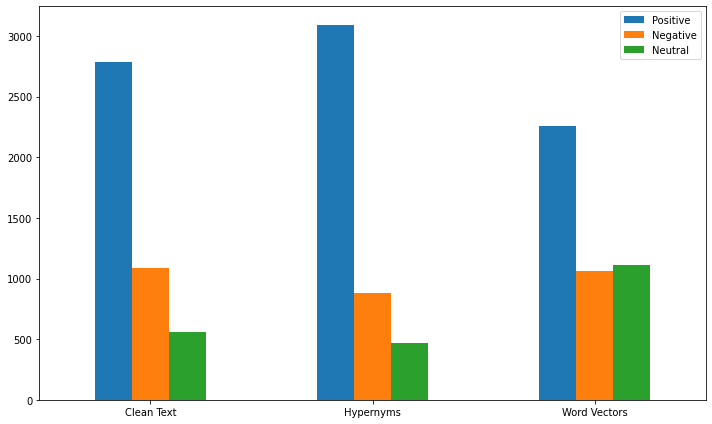

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
senti_score_df.plot(kind='bar' ,ax=ax)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('score_count.png')

## Visualization

In [ ]:
pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7100 sha256=358e39c45d56a5416b9856e2d573de44436a9fecb4920373ee2ae815fc400f18
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [ ]:
from sklearn.manifold import TSNE
import adjustText

In [ ]:
df = open("embeddings_df.pickle", "rb")
embeddings_df = pickle.load(df)

In [ ]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 42, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(embeddings_df[:400])

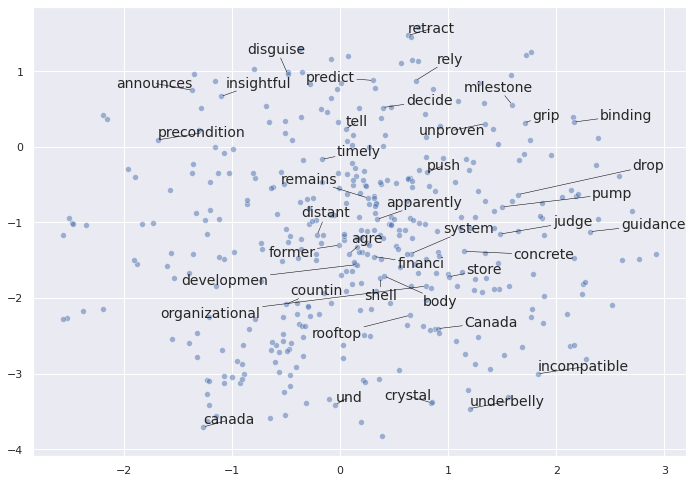

In [ ]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], embeddings_df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.savefig("word_embedding_visualization.png")
plt.show()

In [ ]:
from wordcloud import WordCloud

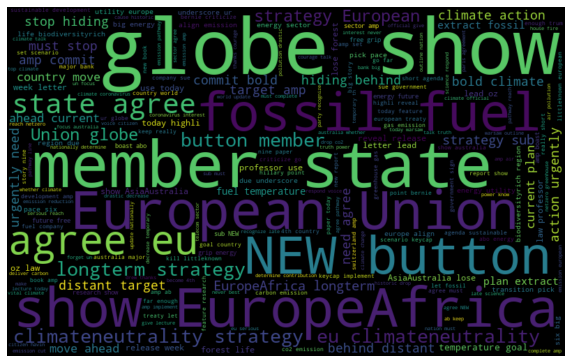

In [ ]:
all_words = " ".join([" ".join(text) for text in processed_df['clean_text']])

# text = " ".join(processed_df['clean_text'][0])

# Create and generate a word cloud image:
# wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(all_words)

# Display the generated image:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig('word_cloud.png')
plt.show()